In [207]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


In [249]:
import seaborn as sns
from matplotlib import pyplot

In [340]:
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [341]:
df = train_data.corr()
df['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

**Drop irrelevant numeric columns - Anything with less than .5 correlation is irrelevant.**

LowQualFinSF - Not sure what it means. No impact on target
MoSold,YrSold - This is unlikely to impact sale price 
KitchenAbvGr
MSSubClass is actually categorical (not numerical)
OverallCond - No correlation with the target variable
Id - Not necessary
BsmtHalfBath - No impact on target variable
BsmtFinSF2 - No impact on target variable. Not sure what Type 1 and Type 2 mean
3SsnPorch - No impact on target variable

**Potentia future columns.**
MiscVal - This might just need to be scaled

In [366]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def drop_nulls(data):
    
    # Drop categorical columns where the two data sets have different values. Look into this!
    data = data.drop(['Utilities', 'HouseStyle', 'RoofMatl', 'Exterior1st', 'Heating', 'Electrical','Condition1','Condition2','Exterior1st','Exterior2nd','ExterQual','ExterCond', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'], axis=1)
    
    # Drop any column that has more than 100 nulls. And drop remaining null values
    data = data.drop(['MiscFeature', 'Alley', 'Fence',], axis=1)
    nulls = pd.DataFrame(data.isna().sum().sort_values(axis=0, ascending=True))
    nulls['Features'] = nulls.index
    nulls.columns = ['Nulls','Features']
    null_columns = nulls[nulls['Nulls'] > 0].sort_values('Nulls', axis=0, ascending=False).index
    
    #fill missing values
    for column in null_columns:
        data[column] = data[column].fillna(data[column].mode()[0])
    
    return data


def process_data(data):
    
    # Drop unecessary numeric features
    data.drop(['LowQualFinSF','MoSold','YrSold','KitchenAbvGr','MSSubClass','OverallCond','Id','BsmtHalfBath','BsmtFinSF2','3SsnPorch','MiscVal'], axis=1, inplace=True)
    
    #Convert categorical variables to dummies
    features = data.columns
    for feature in features:
        if data[feature].dtype != np.float64 and data[feature].dtype != np.int64:
            dummies = pd.get_dummies(data[feature],drop_first=True)
            data = pd.concat([data, dummies], axis=1)
            data.drop(feature, axis=1,inplace=True)
            
    #Scale the data
    scaler = StandardScaler()
    scaler.fit_transform(data)
    
    
    try:
        y = data['SalePrice']
        X = data.drop('SalePrice',axis=1)
    except:
        X = data
        y = 'None'
    
    return X,y

In [380]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

def fitAndScore(X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)
    
    decision_tree = tree.DecisionTreeRegressor()

    param_grid = {
        'max_depth': range(1,10),
    }
    model = GridSearchCV(decision_tree, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=0)
    model.fit(X_train,y_train)
    
    #Calculate rmse
    bestmodel = model.best_estimator_
    y_pred = bestmodel.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)
    rmsle = np.sqrt(mean_squared_log_error(y_test,y_pred))
    
    #Calculate null rmse
    mean = np.mean(y_test)
    y_mean_pred = pd.DataFrame(y_pred)
    y_mean_pred.iloc[:,0] = mean
    mean_rmse = np.sqrt(mean_squared_error(y_test,y_mean_pred))
    mean_rmsle = np.sqrt(mean_squared_log_error(y_test,y_mean_pred))
      
    return {'model': bestmodel, 'out_of_sample_rmse': rmse, 'out_of_sample_r2': r2, 'mean_rmse': mean_rmse,'out_of_sample_rmsle': rmsle,'mean_rmsle': mean_rmsle,'features': X.columns}

In [381]:
train_data_nonulls = drop_nulls(train_data)
X,y = process_data(train_data_nonulls)
train_columns = X.columns

In [382]:
results = fitAndScore(X,y)
print('out_of_sample_rmse: '+str(results['out_of_sample_rmse']))
print('out_of_sample_r2: '+str(results['out_of_sample_r2']))
print('out_of_sample_rmsle: '+str(results['out_of_sample_rmsle']))
print('mean_rmsle: '+str(results['mean_rmsle']))

out_of_sample_rmse: 38355.56741557342
out_of_sample_r2: 0.7908114827258828
out_of_sample_rmsle: 0.1938640349422888
mean_rmsle: 0.4179086010867184


In [375]:
feature_importances = pd.DataFrame({'Feature': results['features'], 'Importances': results['model'].feature_importances_}).sort_values('Importances', ascending=False)
feature_importances[feature_importances['Importances'] > 0]

,Feature,Importances
2,OverallQual,0.643249
11,GrLivArea,0.102629
10,2ndFlrSF,0.067525
8,TotalBsmtSF,0.046913
1,LotArea,0.023721
9,1stFlrSF,0.018381
6,BsmtFinSF1,0.012957
19,GarageCars,0.010425
20,GarageArea,0.006245
100,Y,0.006208


In [371]:
test_data_nonulls = drop_nulls(test_data)
X,y = process_data(test_data_nonulls)
test_columns = X.columns
predictions = results['model'].predict(X)

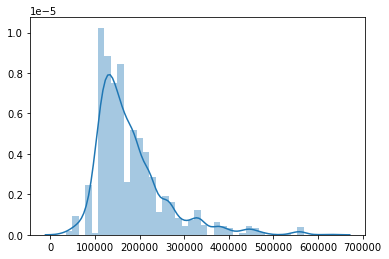

In [373]:
sns.distplot(predictions)

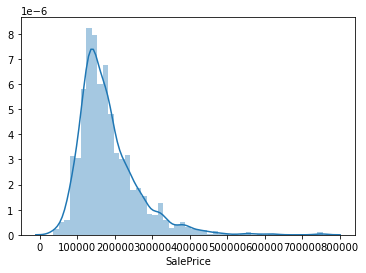

In [374]:
sns.distplot(train_data['SalePrice'])